<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


## Import modules

In [ ]:
# Scikit-learn >=0.24 is required for the HalvingGridSearchCV
!pip install --upgrade scikit-learn

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

! pip install bayesian-optimization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import dump, load
import datetime
import seaborn as sns

from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# %cd /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/
# %pwd

## Define functions

In [4]:
# # Load cv data
# from joblib import dump, load

# model_long_name = "Random Forest"
# model_str = 'rf'
# param_1 = 'n_estimators'
# param_2 = 'max_depth'

# model_load_path = f'{pwd}/models/___ {model_long_name}'

# with open(f'{model_load_path} Grid Search object.joblib', 'rb') as f:
#   gs = load(f)
# with open(f'{model_load_path} Model object.joblib', 'rb') as f:
#   model = load(f)
#   model.fit(X_train, y_train)

### Metrics

In [5]:
def plot_cv_roc_curve(model_short_name, X=None, y=None, is_test=False, ax=None):
  from sklearn.metrics import auc
  from sklearn.metrics import plot_roc_curve
  from sklearn.model_selection import StratifiedKFold

  classifier = models[model_short_name]
  model_long_name = get_model_long_name(model_short_name)

  if type(X)==None:
    X = gs.X_train
  if type(y)==None:
    y = y_train

  # Convert to np array 
  X=X_train.values
  y=y_train.values
  
  # Classification and ROC analysis
  if not is_test:
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # make a new figure and  ax, if no is is define in function call
    if type(ax ) == None:
      fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
          title=f"{model_long_name} with best parameters:\nCross-val ROC curve on training data")
    ax.legend(loc="lower right")
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    title=f"{model_long_name} with best parameters:\nCross-val ROC curve on training data")
  else:
    # make a new figure and  ax, if no is is define in function call
    if type(ax ) == None:
      fig, ax = plt.subplots()

    viz = plot_roc_curve(classifier, X, y,
                          name='test',
                          lw=2, ax=ax)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title=f"{model_long_name} with best parameters:\nCross-val ROC curve on test data")
  return ax


In [6]:
  def plot_conf_matrix(model_short_name, X=None, y=None, is_test=False, ax=None):

    fitted_model = models[model_short_name]
    model_long_name = get_model_long_name(model_short_name)

    if type(X)==None:
      X = X_train
    if type(y)==None:
      y = y_train

    # Using best CV parameters, on the test data:
    # Plot normalized confusion matrix
    confmat = plot_confusion_matrix(fitted_model, X, y,
                                    cmap=plt.cm.Blues,
                                    normalize='true', 
                                    colorbar=False,
                                    ax=ax)
    if is_test==False:
      confmat.ax_.set_title(f"{model_long_name} with best parameters:\nNormalized confusion matrix on training data")
    else:
      confmat.ax_.set_title(f"{model_long_name} with best parameters:\nNormalized confusion matrix on test data")
    return confmat
  

In [7]:
def plot_prec_recall_curve(model_short_name, X=None, y=None, is_test=False, ax=None):
    from sklearn.metrics import plot_precision_recall_curve

    fitted_model = models[model_short_name]
    model_long_name = get_model_long_name(model_short_name)

    if fitted_model==None:
      fitted_model = model
    if type(X)==None:
      X = X_train
    if type(y)==None:
      y = y_train
      
    prc = plot_precision_recall_curve(fitted_model, X, y, ax=ax)
   
    if is_test==False:
      prc.ax_.set_title(f"{model_long_name} with best parameters:\nPrecision Recall Curve on training data")
    else:
      prc.ax_.set_title(f"{model_long_name} with best parameters:\nPrecision Recall Curve on test data")

    return prc

In [8]:
def plot_metrics(model_short_name):
  fig, ax = plt.subplots(3, 2, figsize=(10, 15))
  plot_cv_roc_curve(model_short_name, X_train, y_train, ax=ax[0, 0])
  plot_cv_roc_curve(model_short_name, X_test, y_test, is_test=True, ax=ax[0, 1])
  plot_conf_matrix(model_short_name, X_train, y_train, ax=ax[1, 0])
  plot_conf_matrix(model_short_name, X_test, y_test, is_test=True, ax=ax[1, 1])
  plot_prec_recall_curve(model_short_name, X_train, y_train, ax=ax[2, 0])
  plot_prec_recall_curve(model_short_name, X_test, y_test, is_test=True, ax=ax[2, 1])
  fig.tight_layout()

### Hyperparameter Tuning

In [9]:
def get_model_long_name(short_name):
  switch = {'dt':'Decision Tree',
            'rf':'Random Forest',
            'log_reg':'Logistic Regression',
            'lgbm':'LightGBM',
            'sgd':'Stochastic Gradient Descent'}
  return switch.get(short_name, None)



In [10]:
def plot_hyperparameter_search_results(optimizer_type, short_name, *params):
  from matplotlib import ticker
  model_long_name = get_model_long_name(short_name)

  # Set GS or BO cv_results lookup
  if optimizer_type == 'gs':
    cv_results = gs_cv_results[short_name]
  else:
    cv_results = bo_cv_results[short_name]

  #Make formatted title based on num of params
  title_string = f'{model_long_name}:\nMean 5-fold-CV ROC AUC score vs.'
  if len(params) == 1:
    title_string = title_string + ' ' + params[0]
  else:
    for param in params[:-1]:
      title_string = title_string + ' ' + param
    title_string = title_string + ' and ' + params[-1]
  
  #If importing a gs_rs_cv_results dataframe
  if 'mean_cv_roc_auc_score' in cv_results.columns.values:
    x = params
    y = 'mean_cv_roc_auc_score'
  #If importing a bayes_opt_cv_results dataframe
  else:
    x= [f'param_{param}' for param in params]
    y = 'mean_test_score'

  # Convert param dtypes cv_results for better handling in plot
  for i in x:
    if cv_results[i].dtype=='object':
      try:
        cv_results[i] = cv_results[i].astype(int)
      except ValueError:
        try:
          cv_results[i] = cv_results[i].astype(float)
        except ValueError:
          cv_results[i] = cv_results[i].astype('string')

  # Identify numerical and categorical and boolean params
  if type(x) == tuple:
    x = list(x)
  x_cat = cv_results[x].select_dtypes(['category', bool]).columns.values
  x_cat = list(x_cat)
  x_num = cv_results[x].select_dtypes('number').columns.values
  x_num = list(x_num)
  if len(x_cat)==0:
    x_cat = list(cv_results[x].drop(columns=x_num).columns.values)

  # Rename y col for better readability on plot
  if 'mean_cv_roc_auc_score' in cv_results.columns.values: #bo
    cv_results['ROC_AUC'] = cv_results[y]
    # cv_results.drop(columns='mean_cv_roc_auc_score', inplace=True)
    x = params
  else: #gs
    cv_results['ROC_AUC'] = cv_results[y] 
    # cv_results.drop(columns='mean_test_score', inplace=True)
    x = [f'param_{param}' for param in params]
  y = 'ROC_AUC'
  
  # Make one ax for each num param
  fig, axes = plt.subplots(1, len(x_num), figsize=(5*len(x_num), 5), sharey=True)
  fig.suptitle(title_string)

  def plot_ax(i, ax, hue=None):
    if len(x_cat) > 0:
      hue = x_cat[0]
    p = sns.pointplot(data=cv_results,
                    x= x[i],
                    y= y,
                    dodge=True,
                    join=False,
                    ax=ax, 
                    hue=hue)
    # Plot integer xticks, only when the dtype is not a type pd.Categorical
    if not hasattr(cv_results[x[i]], 'cat'):
      # Show only every 4-th tick
      for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 4 != 0:
          label.set_visible(False)
    # Truncate long decimals
    if cv_results[x[i]].dtype == float:
      ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
    # Rotate ticks only if their are a lot
    if len(ax.get_xticklabels()) > 6:
      for tick in ax.get_xticklabels():
        tick.set_rotation(60)
    return p
  if len(x_num) == 1:
    plot_ax(0, axes)
  else:
    for i, ax in enumerate(axes):
      plot_ax(i, ax)

#### Grid Search Optimization

In [11]:
def save_gs_search_results_and_model(gs=None, model_str=None):
  from joblib import dump, load
  import datetime

  model_long_name = get_model_long_name(model_str)

  # Save the search results and models in a dict
  best_params[model_str] = gs.best_params_
  gs_cv_results[model_str] = pd.DataFrame(gs.cv_results_)
  scores[model_str] = gs.best_score_
  models[model_str] = model
  
  # Save the model and gridsearch objects to hard drive
  model_save_path = f'{pwd}/models/{datetime.datetime.now():%Y-%m-%d %H%M} {model_long_name}'
  dump(model, f'{model_save_path} Model object.joblib')
  dump(gs, f'{model_save_path} Grid Search object.joblib')

  # Print the scores and parameters
  print(f"Best Params: {best_params[model_str]}")
  print(f"Best CV Score: {scores[model_str]:0.4f}")

#### Bayesian Optimization

In [12]:
# Define the metric to optimize over: Mean CV roc_auc_score
def eval_model(**kwargs):
  for param in kwargs.keys():
    # Some params must be int so we recast them first
    if param in ['n_estimators', 'max_depth', 'num_leaves']:
      kwargs[param] = int(kwargs[param])
    # Some params are strings
    elif param == 'criterion':
      i = round(kwargs[param])
      kwargs[param] = 'gini' if i==0 else 'entropy'
    elif param == 'loss':
      switch = {0: 'hinge', 
                1: 'modified_huber', 
                2: 'squared_hinge',
                3: 'perceptron'}
      kwargs[param] = switch.get(round(kwargs[param]), None)
  
    #   kwargs['criterion'] = int(kwargs['n_estimators'])
    # if param == 'max_depth':
    #   kwargs['max_depth'] = int(kwargs['max_depth'])
    # if param == 'num_leaves':
    #   kwargs['num_leaves'] = int(kwargs['num_leaves'])
  model.set_params(**kwargs)
  cv_scores = cross_val_score(model, 
                                  X_train, 
                                  y_train, 
                                  scoring='roc_auc',
                                  cv=5)
  return cv_scores.mean()

In [13]:
def run_bayes_opt(eval_model, pbounds, n_iter=15, kappa=10):
  from bayes_opt import BayesianOptimization
  from bayes_opt import SequentialDomainReductionTransformer

  def plot_bo(f, bo):
    x = np.linspace(-2, 10, 10000)
    mean, sigma = bo._gp.predict(x.reshape(-1, 1), return_std=True)
    
    plt.figure(figsize=(16, 9))
    plt.plot(x, f(x))
    plt.plot(x, mean)
    plt.fill_between(x, mean + sigma, mean - sigma, alpha=0.1)
    plt.scatter(bo.space.params.flatten(), bo.space.target, c="red", s=50, zorder=10)
    plt.show()
  
  init_points= 2 ** (len(pbounds))

  # the optional bounds_transformer should speed convergence
  bounds_transformer = SequentialDomainReductionTransformer()

  # create BayesianOptimization object, and optimize
  bo = BayesianOptimization(f = eval_model, 
                                  pbounds = pbounds, 
                                  verbose = 2,
                                  bounds_transformer=bounds_transformer)
  bo.maximize(init_points = init_points,
              n_iter = n_iter,
              acq="ucb", 
              kappa=kappa)
  
  # Parse results and save
  best_params[model_str] = parse_bo_best_params(bo) 
  bo_cv_results[model_str]= save_bayes_opt_results(bo, model_str)
  return bo

In [14]:
def parse_bo_best_params(bo):
  kwargs = bo.max['params']

  for param in kwargs.keys():
    # Some params must be int so we recast them first
    if param in ['n_estimators', 'max_depth', 'num_leaves']:
      kwargs[param] = int(kwargs[param])

    # Some params are strings
    elif param == 'criterion':
      i = round(kwargs[param])
      kwargs[param] = 'gini' if i==0 else 'entropy'
    elif param == 'loss':
      switch = {0: 'hinge', 
                1: 'modified_huber', 
                2: 'squared_hinge',
                3: 'perceptron'}
      kwargs[param] = switch.get(round(kwargs[param]), None)
  
  return kwargs

In [15]:
def save_bayes_opt_results(bo, model_str):
  # Parse results
  list_dfs = []
  counter = 0
  # bo.res is a list of dicts
  for result in bo.res:
      df_temp = pd.DataFrame.from_dict(data=result['params'], orient='index',
                                        columns=['trial ' + str(counter)]).T
      df_temp['mean_cv_roc_auc_score'] = result['target']
      list_dfs.append(df_temp)
      counter = counter + 1
        
  df = pd.concat(list_dfs, axis=0)

  # Format results for easier plotting
  for col in df.columns.values:
    # Some params must be int so we recast them first
    if col in ['n_estimators', 'max_depth', 'num_leaves']:
      df[col] = df[col].astype(int)
    # Some params are strings
    elif col == 'criterion':
      s = df[col]
      df[col] = s.where(s.astype(float)<0.5, 'gini').where(s.astype(float)>0.5, 'entropy').astype('category')
    elif col == 'loss':
      switch = {0: 'hinge', 
                1: 'modified_huber', 
                2: 'squared_hinge',
                3: 'perceptron'}
      df[col] = df[col].astype(int).map(switch).astype('category')

  # Save results
  model_long_name = get_model_long_name(model_str)
  model_save_path = f'{pwd}/models/{datetime.datetime.now():%Y-%m-%d %H%M} {model_long_name}'
  df.to_pickle(model_save_path + ' df_bayes_opt_results_parameters.pkl')
  print(f"Saved file to {model_save_path + ' df_bayes_opt_results_parameters.pkl'}")
  df.to_csv(model_save_path + ' df_bayes_opt_results_parameters.csv')
  print(f"Saved file to {model_save_path + ' df_bayes_opt_results_parameters.csv'}")

  return df

#Import the data

 The data has been pre-split into train and test sets.


In [16]:
pwd = '/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction'
suffix = '.pkl.gzip'

# #Define data paths
X_train = pd.read_pickle(f'{pwd}/data/intermediate/feature_engineered/X_train{suffix}')
y_train = pd.read_pickle(f'{pwd}/data/intermediate/feature_engineered/y_train{suffix}')

X_test = pd.read_pickle(f'{pwd}/data/intermediate/feature_engineered/X_test{suffix}')
y_test = pd.read_pickle(f'{pwd}/data/intermediate/feature_engineered/y_test{suffix}')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19548, 218), (19548,), (19519, 218), (19519,))

# Principle Component Analysis

Before continuing with modelling, let's check if PCA is useful for our data set.

pca_explained_variance_ratio[100].sum():  0.9837462560456656



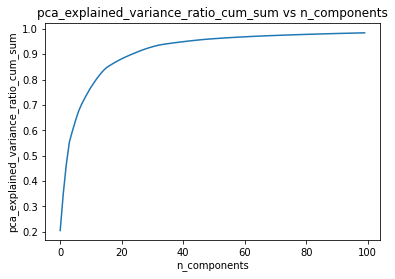

CPU times: user 2.7 s, sys: 2.84 s, total: 5.53 s
Wall time: 1.85 s


In [17]:
%%time

from sklearn.decomposition import PCA

pca_explained_variance_ratio = {}

pca = PCA(n_components=100)
pca.fit(X_train)
pca_explained_variance_ratio[100] = pca.explained_variance_ratio_

print(f"pca_explained_variance_ratio[100].sum():  {pca_explained_variance_ratio[100].sum()}\n")

pca_explained_variance_ratio_cum_sum = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(data=pca_explained_variance_ratio_cum_sum)
plt.title('pca_explained_variance_ratio_cum_sum vs n_components')
plt.xlabel('n_components')
plt.ylabel('pca_explained_variance_ratio_cum_sum')

plt.show();

It appears that PCA is effective on this dataset. The 100 most important PCA components expalain more than 98% of the variance.

# Selection Considerations

## Model

Before choosing a model, let's take inventory of what kind of problem we are trying to solve. We have a supervised learning classification problem with 20000 million sample, expandable to 100 million samples. There are categorical, numerical, and boolean features, but no textual features. In bullet ponts:

* Superivised learning 
* Classification problem (binary)
* 20000 samples, expandable to 100 million samples
* Features dtypes are categorical, numerical, and boolean, but not textual.

As a first step in the model selection criteria, let's reference the [Scikit-learn algorithm selection cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).
![](https://scikit-learn.org/stable/_static/ml_map.png)

Based on the chart, the models to consider are SGD Classifier, Linear SVC, and Ensemble Classifiers.

As a second source of inspiration, I compared the [published notebooks of leading Kaggle competitors on modeling this data set](https://www.kaggle.com/c/riiid-test-answer-prediction/code). Gradient boosting models, such as XGBoost, LightGBM, and AdaBoost, are a poplular choice.

Additionally, we consisider decision tree and random forest, as they work well with many types of data and are quick to train.

Some of these models are quite similar, so for this baseline modeling we will only consider the following five models:
* Decision Tree 
* Random Forest
* Logistic Regression
* SGD Classifier
* LightGBM

Even though Logistic Regression can be considered a special case of SGD, the Scikit-learn implementation for each is different enough that we can consider them seperately.

## Hyperparameters

As this is a baseline modeling notebook, we don't intend to tune all the hyperparameters on each model. For this analysis, we'll select two or three well-understood hyperparameter for each model.

The selected hyperparameters for each model are:

Decision Tree
* max depth of tree: `max_depth`
* splitting criterion for each branch: `criterion`

Random Forest
* number of trees in forest: `n_estimators`
* max depth of each tree: `max_depth`

Logistic Regression
* Regularization parameter: `C`
* Norm used in penalization: `l1_Ratio`




## Optimization
Hyperparameters will be quickly optimized with both HalvingGridSearchCV and Bayesian Optimzation. The results will be compared to see if the extra complexity of implementing the Bayesian Optimization results in better model performance.

Summarizing the differences: 
* HalvingGridSearchCV optimization will iteratively and exhaustivly search the hyperparamter grid usings a tiny subset of the available data (about 1%), and top scoring fraction (about 30%) of hyperparamters will be re-scored on a larger fraction of the data, until the final hyperparamter set is scored on the entire data. Only about 2% of the search space will be scored on the entire data set, saving lots of time.
* The Bayesian Optimization will predict a few promising hyperparameter sets and then score each one with the entire sample set. The score of the previous hyperparameter set informs the predictions for the selecting the next hyperparameter set to test. The prediction algorithm avoid testing hyperparameters that are unlikely to improve on the current best score, saving lots of time.




# Modeling on Feature-engineered Data

In a previous notebook, we did some basic feature engineering on the data. Please see that details at https://github.com/allen44/riiid-test-answer-prediction/blob/main/feature_engineering.ipynb

## Store the best metrics and best paramters for each model

In [18]:
# Best parameters and best scores
scores = {}
best_params = {}
gs_cv_results = {}
bo_cv_results = {}
models = {}

## Decision Tree Classifier

Pros:

* good at handling mixed dtypes,
* good at handling missing values,
* robust to outliers in inputs,
* insensative to monotone transformations of inputs,
* computationally efficient at large data sets,
* insensative to colinearrity of features

Cons:

* Low predictive power, relative to state-of-the-art research
* Can't extract linear combinations of features
* Large trees are difficult to interpret

### Hyperparamater Tuning

#### Grid Search


##### Optimization

In [19]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_str = 'dt'

# Instantiate classifier object
model= DecisionTreeClassifier(class_weight = 'balanced')

# Set parameter grid and instantiate HalvingGridSearchCV object
max_depth = [i for i in range(2, 50, 1)]
criterion = ['gini', 'entropy']

param_grid = {'max_depth': max_depth,
              'criterion': criterion}

gs = HalvingGridSearchCV(model, 
                  param_grid, 
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1)
          
# Fit classifier
gs.fit(X_train, y_train)

# Set the best parameters in the the classifier and fit the train data
model.set_params(**gs.best_params_) 
model.fit(X_train, y_train)

# Save the results
save_gs_search_results_and_model(gs, model_str)

Best Params: {'criterion': 'gini', 'max_depth': 5}
Best CV Score: 0.9168
CPU times: user 2.57 s, sys: 184 ms, total: 2.75 s
Wall time: 14 s


##### Results

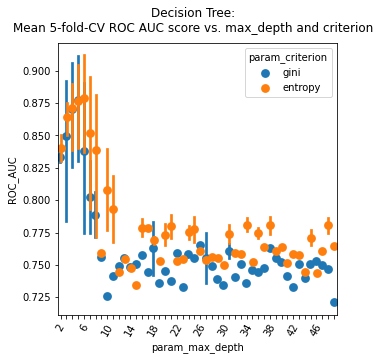

In [20]:
plot_hyperparameter_search_results('gs', 'dt', 'max_depth', 'criterion')

#### Bayesian Optimization

In addition to optimizing hyperparameters with grid search, we'll also compare the results with bayesian optimization. The research shows that Bayesian optimization can converge to the global max 3 to 10 times faster than random search, and even faster than grid search--depending on the model and the data. The tradeoff is that grid search and random search are trivial to parallelize, but bayesian optimization is not.

##### Optimization

In [21]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_str = 'dt'

# Instantiate classifier object
model= DecisionTreeClassifier(class_weight = 'balanced')

# set range of params to optimize over
pbounds = {"max_depth": [2, 100],
           "criterion": [0, 1]}

# Run optimization and save results
bo = run_bayes_opt(eval_model, 
                   pbounds, 
                   n_iter = 60)

# Set model to best params and fit to train data
model.set_params(**best_params[model_str])
model.fit(X_train, y_train)
models[model_str] = model

|   iter    |  target   | criterion | max_depth |
-------------------------------------------------
|  1        |  0.8434   |  0.2708   |  46.51    |
|  2        |  0.8403   |  0.6526   |  44.7     |
|  3        |  0.8431   |  0.09523  |  76.5     |
|  4        |  0.9172   |  0.7556   |  13.37    |
|  5        |  0.845    |  0.4929   |  2.0      |
|  6        |  0.8532   |  0.9919   |  24.33    |
|  7        |  0.8402   |  0.5428   |  34.0     |
|  8        |  0.922    |  0.947    |  8.42     |
|  9        |  0.883    |  1.0      |  18.56    |
|  10       |  0.9266   |  1.0      |  10.81    |
|  11       |  0.9083   |  1.0      |  5.906    |
|  12       |  0.9033   |  1.0      |  15.71    |
|  13       |  0.9213   |  0.9993   |  12.16    |
|  14       |  0.9246   |  0.9058   |  9.702    |
|  15       |  0.9188   |  0.9152   |  7.208    |
|  16       |  0.9249   |  0.9237   |  11.3     |
|  17       |  0.9266   |  0.9319   |  10.47    |
|  18       |  0.9266   |  0.9994   |  10.08    |


##### Results

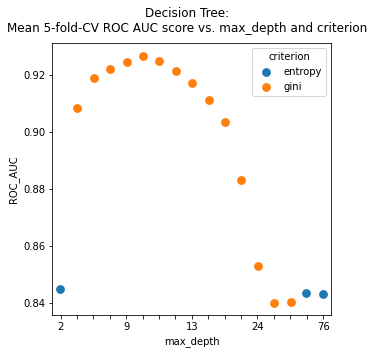

In [22]:
plot_hyperparameter_search_results('bo', 'dt', 'max_depth', 'criterion')

### Metrics

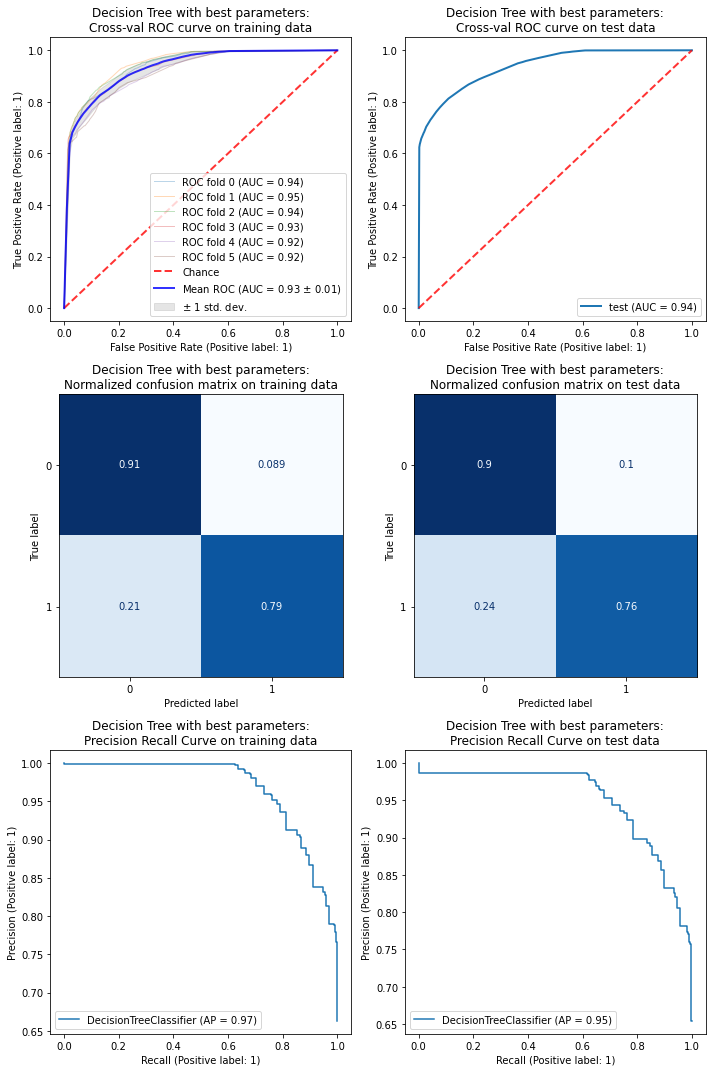

In [23]:
plot_metrics('dt')

## Random Forest Classifier

Pros:

* Higher predictive power than individual compenents,
* Good at handling mixed dtypes,
* Good at handling missing values,
* Robust to outliers in inputs,
* Insensitive to monotonic transformations of inputs,
* Insensitive to colinearrity of features

Cons:

* less efficient at large data sets, 
* the complete forest is difficult to interpret

### Hyperparamater Tuning


#### Grid Search

#####Optimization

In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier

model_long_name = "Random Forest"
model_str = 'rf'
param_1 = 'n_estimators'
param_2 = 'max_depth'

# Instantiate classifier object
model = RandomForestClassifier(class_weight='balanced')

# Set parameter grid and instantiate HalvingGridSearchCV object
param_grid = {'n_estimators': list(set(np.logspace(0, 3.5, 15, dtype=int))),
              'max_depth': [2, 4, 8, 16, 25, 30, 35, 40, 50, 60]
              }

gs = HalvingGridSearchCV(model, 
                  param_grid, 
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1, 
                  verbose=3)
    
# Fit classifier
gs.fit(X_train, y_train)

# Set the best parameters in the the classifier and fit the train data
model.set_params(**gs.best_params_) 
model.fit(X_train, y_train)

# Save the results
save_gs_search_results_and_model(gs, model_str)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 241
max_resources_: 19548
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 140
n_resources: 241
Fitting 5 folds for each of 140 candidates, totalling 700 fits
----------
iter: 1
n_candidates: 47
n_resources: 723
Fitting 5 folds for each of 47 candidates, totalling 235 fits
----------
iter: 2
n_candidates: 16
n_resources: 2169
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 6
n_resources: 6507
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


----------
iter: 4
n_candidates: 2
n_resources: 19521
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Params: {'max_depth': 35, 'n_estimators': 1000}
Best CV Score: 0.9814
CPU times: user 1min 41s, sys: 2.93 s, total: 1min 43s
Wall time: 21min 30s


##### Results

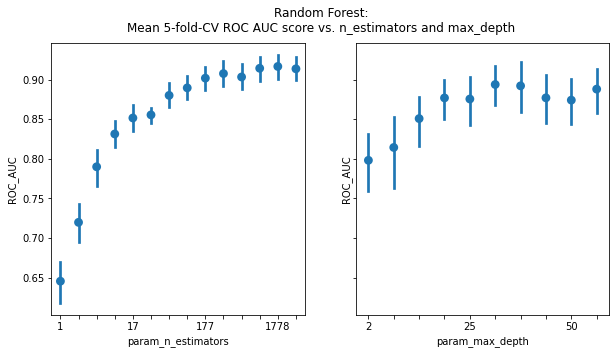

In [25]:
plot_hyperparameter_search_results('gs', 'rf', 'n_estimators', 'max_depth')

#### Bayesian Optimization

##### Optimization

In [26]:
%%time
from sklearn.ensemble import RandomForestClassifier

model_str = 'rf'

# Instantiate classifier object
model = RandomForestClassifier(class_weight='balanced')

# set range of params to optimize over
pbounds = {"n_estimators": [10, 2000],
           "max_depth": [1, 25],}

# Run optimization and save results
bo = run_bayes_opt(eval_model, 
                   pbounds, 
                   n_iter = 15)

# Set model to best params and fit to train data
model.set_params(**best_params[model_str])
model.fit(X_train, y_train)
models[model_str] = model

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.9272   |  9.319    |  1.986e+0 |
|  2        |  0.9333   |  10.77    |  1.949e+0 |
|  3        |  0.9556   |  15.21    |  1.233e+0 |
|  4        |  0.8851   |  4.215    |  474.4    |
|  5        |  0.9705   |  22.03    |  1.562e+0 |
|  6        |  0.9744   |  25.0     |  1.094e+0 |
|  7        |  0.975    |  25.0     |  813.9    |
|  8        |  0.9678   |  20.15    |  947.9    |
|  9        |  0.9737   |  25.0     |  660.8    |
|  10       |  0.972    |  23.08    |  821.3    |
|  11       |  0.9737   |  24.35    |  816.4    |
|  12       |  0.9703   |  21.82    |  731.6    |
|  13       |  0.9753   |  25.0     |  1.011e+0 |
|  14       |  0.9741   |  25.0     |  1.162e+0 |
|  15       |  0.9747   |  25.0     |  890.6    |
|  16       |  0.9714   |  22.91    |  1.052e+0 |
|  17       |  0.9725   |  23.2     |  1.129e+0 |
|  18       |  0.9747   |  25.0     |  979.0    |


##### Results

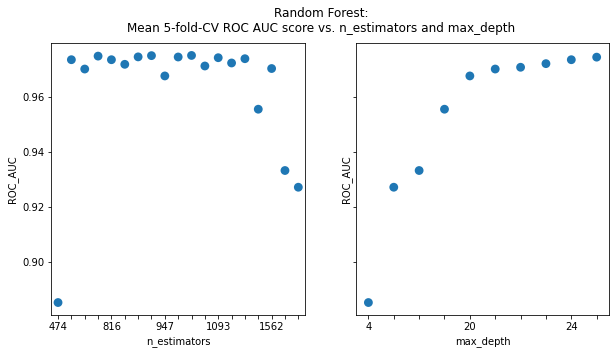

In [27]:
plot_hyperparameter_search_results('bo', 'rf', 'n_estimators', 'max_depth')

### Metrics

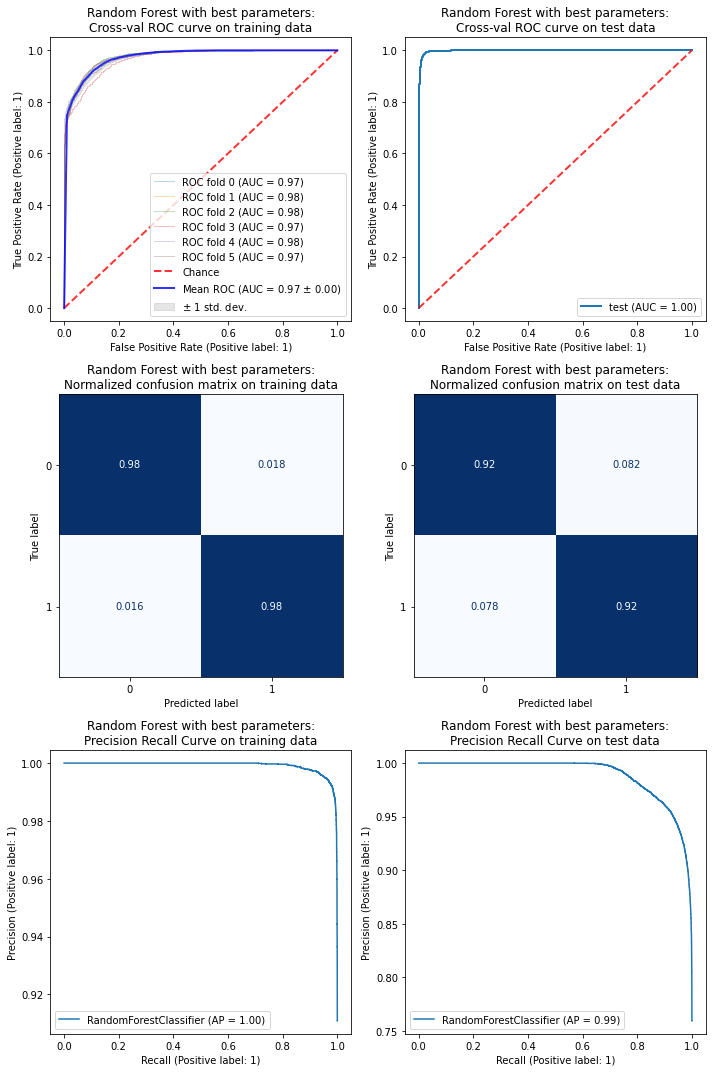

In [28]:
plot_metrics('rf')

## Logistic Regression Classifier

Pros:

* Easy to implement, interpret, and very efficient to train.	
* Makes no assumptions about distributions of classes in feature space.
* Easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.	
* Not only provides a measure of how appropriate a predictor(coefficient size) is, but also its direction of association (positive or negative).	
* Very fast at classifying unknown records.	
* Good accuracy for many simple data sets and it performs well when the dataset is linearly separable.
* Model coefficients can be interpretted as indicators of feature importance.	
* Less likely to over-fit but it can overfit in high dimensional datasets. Regularization (L1 and L2) can be used to avoid over-fitting in these scenarios.



Cons: 

* Assumes linearity between the dependent variable and the independent variables (Major limitation).
* Only constructs linear boundaries.
* May overfit if the number of observations is less than the number of features.
* Can only be used to predict discrete functions. Hence, the dependent variable of Logistic Regression is bound to the discrete number set.
* Can't solve non-linear problems because it has a linear decision surface. Linearly separable data is rarely found in real-world scenarios.
* Requires average or no multicollinearity between independent variables.
* Tough to obtain complex relationships using logistic regression. More powerful and compact algorithms such as Neural Networks can easily outperform this algorithm.
* In contrast with Linear Regression--whose independent and dependent variables are related linearly--Logistic Regression requires that independent variables are linearly related to the log odds (log(p/(1-p)).


### Hyperparamater Tuning

#### Grid Search

##### Optimization

In [29]:
%%time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

model_long_name = 'Logistic Regression Classifier'
model_str = 'log_reg'
param_1 = 'C'
param_2 = 'l1_ratio'

# Instantiate classifier object
model = LogisticRegression(solver='saga',
                            penalty='elasticnet',
                            class_weight='balanced')

# Set parameter grid and instantiate HalvingGridSearchCV object
param_grid = {'C': np.logspace(-3, 4, 7),
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
              }

gs = HalvingGridSearchCV(model, 
                  param_grid, 
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1, 
                  verbose=3)
          
# Fit classifier
gs.fit(X_train, y_train)

# Set the best parameters in the the classifier and fit the train data
model.set_params(**gs.best_params_) 
model.fit(X_train, y_train)

# Save the results
save_gs_search_results_and_model(gs, model_str)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 724
max_resources_: 19548
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 724
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 2172
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 6516
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 19548
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Params: {'C': 0.21544346900318845, 'l1_ratio': 1}
Best CV Score: 0.9229
CPU times: user 17.4 s, sys: 362 ms, total: 17.8 s
Wall time: 1min 30s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### Results

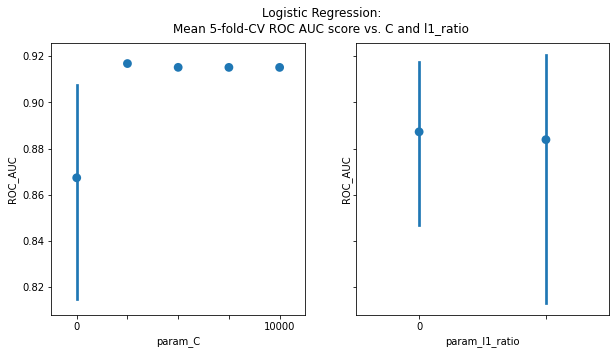

In [30]:
plot_hyperparameter_search_results('gs', 'log_reg', 'C', 'l1_ratio')

#### Bayesian Optimization

##### Optimization

In [31]:
%%time
from sklearn.linear_model import LogisticRegression

model_long_name = 'Logistic Regression Classifier'
model_str = 'log_reg'
param_1 = 'C'
param_2 = 'l1_ratio'

# Instantiate classifier object
model = LogisticRegression(solver='saga',
                            penalty='elasticnet',
                            class_weight='balanced')


# set range of params to optimize over
pbounds = {'C': [0, 1000],
           'l1_ratio': [0, 1],}

# Run optimization and save results
bo = run_bayes_opt(eval_model, 
                   pbounds,
                   n_iter = 15)

# Set model to best params and fit to train data
model.set_params(**best_params[model_str])
model.fit(X_train, y_train)
models[model_str] = model

|   iter    |  target   |     C     | l1_ratio  |
-------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  1        |  0.9205   |  320.9    |  0.2201   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  2        |  0.9205   |  866.7    |  0.9336   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  3        |  0.9205   |  439.9    |  0.5995   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  4        |  0.9205   |  407.6    |  0.4767   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  5        |  0.9205   |  864.8    |  0.8235   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  6        |  0.9205   |  966.8    |  0.9529   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  7        |  0.9205   |  735.6    |  0.8084   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  8        |  0.9205   |  723.5    |  0.9948   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  9        |  0.9205   |  866.7    |  0.9531   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  10       |  0.9205   |  752.3    |  0.9846   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  11       |  0.9205   |  777.2    |  0.9108   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  12       |  0.9205   |  702.6    |  0.9677   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  13       |  0.9205   |  784.7    |  0.9305   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  14       |  0.9205   |  795.3    |  0.9542   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  15       |  0.9205   |  784.4    |  0.9924   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  16       |  0.9205   |  771.1    |  0.9898   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  17       |  0.9205   |  793.4    |  0.9605   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  18       |  0.9205   |  707.3    |  0.9904   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  19       |  0.9205   |  794.8    |  0.9664   |
Saved file to /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/models/2021-04-24 2020 Logistic Regression df_bayes_opt_results_parameters.pkl
Saved file to /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/models/2021-04-24 2020 Logistic Regression df_bayes_opt_results_parameters.csv
CPU times: user 11min 3s, sys: 31.1 s, total: 11min 34s
Wall time: 10min 56s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### Results

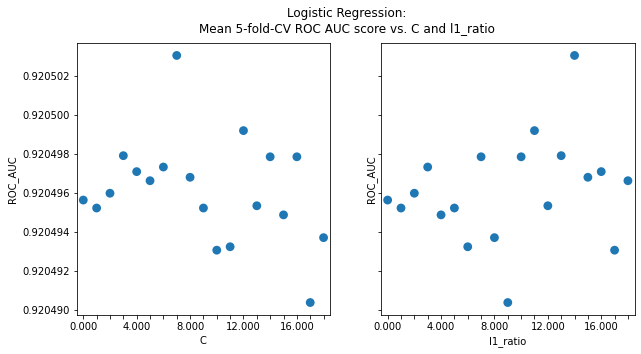

In [32]:
plot_hyperparameter_search_results('bo', 'log_reg', 'C', 'l1_ratio')

Based on these plots, we see that 

* param_C is best at about 0.1,
* and param_l1_ratio almost does not matter.

We'll set the parameters to C=0.1, l1_ratio=0.5.

### Metrics

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

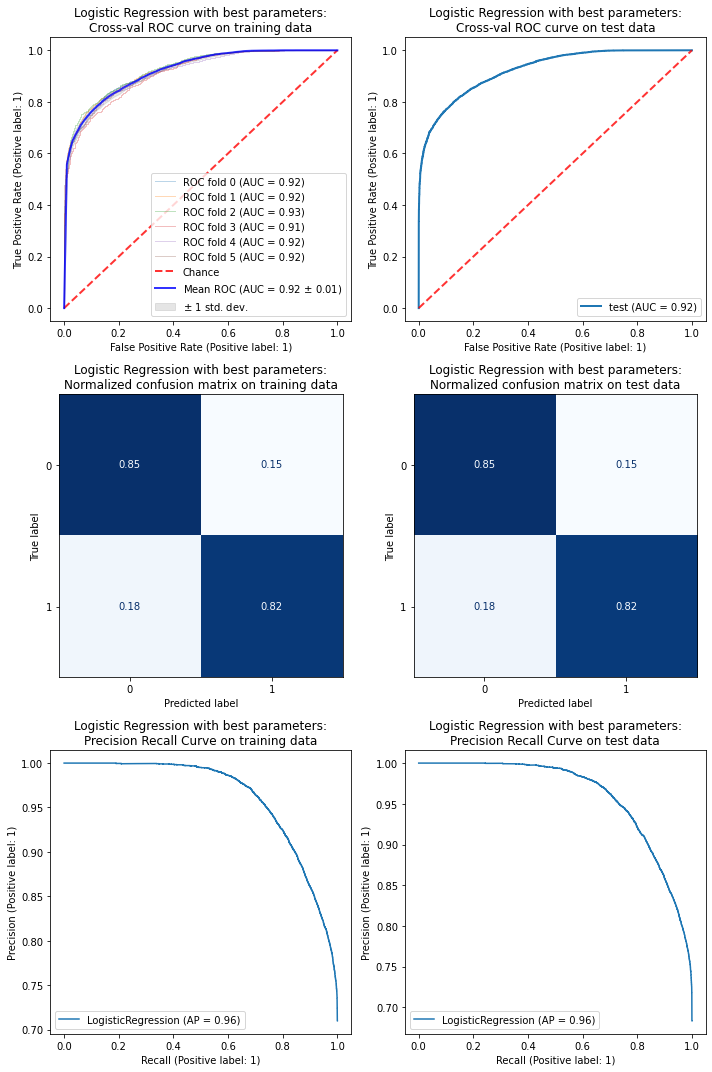

In [33]:
plot_metrics('log_reg')

That's a pretty bad score for a baseline model. It's good in training, and terrible in test.


## LightGBM Classifier

### When to use LightGBM

* Large number of training samples
* Greater than 1000 training samples and less 100 features
* The number of features < number of training samples
* Data has a mixture of categorical and numeric features or just numeric features

### When to NOT use LightGBM 

* Another best-in-class algorithm is already known to be well suited for the task (such as neural nets for computer vision and natural language processing and understanding problems)
* When the number of training samples is significantly smaller than the number of features

LightGBM is an ideal model for this data subset. However, if we elect to expand the analysis to the entire dataset (100 millions rows), then LightGBM would be an even better choice.


### Hyperparamater Tuning

#### Grid Search

##### Optimization

In [34]:
%%time
from lightgbm import LGBMClassifier

model_str = 'lgbm'

# Instantiate the classifier object
model = LGBMClassifier(
    class_weight = 'balanced',
    objective = 'binary',
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

# Set parameter grid and instantiate HalvingGridSearchCV object
param_grid = {'num_leaves': list(set(np.logspace(np.log10(10),np.log10(1000), 10, dtype=int))),
              'max_depth': list(set(np.logspace(np.log10(1),np.log10(10), 10, dtype=int))),
              'n_estimators': list(set(np.logspace(np.log10(10),np.log10(1000), 10, dtype=int)))
              }

gs = HalvingGridSearchCV(model, 
                  param_grid, 
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1, 
                  verbose=3)
    
# Fit classifier
gs.fit(X_train, y_train)

# Set the best parameters in the the classifier and fit the train data
model.set_params(**gs.best_params_) 
model.fit(X_train, y_train)

# Save the results
save_gs_search_results_and_model(gs, model_str)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 80
max_resources_: 19548
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 700
n_resources: 80
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
----------
iter: 1
n_candidates: 234
n_resources: 240
Fitting 5 folds for each of 234 candidates, totalling 1170 fits
----------
iter: 2
n_candidates: 78
n_resources: 720
Fitting 5 folds for each of 78 candidates, totalling 390 fits
----------
iter: 3
n_candidates: 26
n_resources: 2160
Fitting 5 folds for each of 26 candidates, totalling 130 fits
----------
iter: 4
n_candidates: 9
n_resources: 6480
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 5
n_candidates: 3
n_resources: 19440
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params: {'max_depth': 3, 'n_estimators': 359, 'num_leaves': 27}
Best CV Score: 0.9991
CPU times: user 19.6 s, sys: 714 ms, total: 20.3 s
Wall time: 1min 13

#####Results

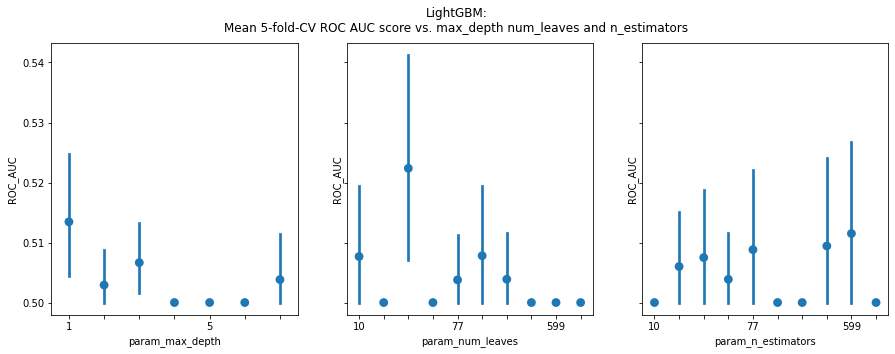

In [35]:
plot_hyperparameter_search_results('gs', 
                                   'lgbm', 
                                   'max_depth', 
                                   'num_leaves', 
                                   'n_estimators')

In [36]:
# # Load model and cv data
# from joblib import dump, load

# model_long_name = 'LGBM'
# model_str = 'lgbm'

# model_load_path = f'{pwd}/models/___ {model_long_name}'

# with open(f'{model_load_path} Grid Search object.joblib', 'rb') as f:
#   gs = load(f)
# with open(f'{model_load_path} Model object.joblib', 'rb') as f:
#   model = load(f)

#### Bayesian Optimization

##### Optimization

In [37]:
%%time
from lightgbm import LGBMClassifier

model_str = 'lgbm'

# Instantiate the classifier object
model = LGBMClassifier(
    class_weight = 'balanced',
    objective = 'binary',
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

# Parameters
pbounds = {'num_leaves': [1, 1000],
            'max_depth': [1, 10],
            'n_estimators': [20, 1000]
            }

# Run optimization and save results
bo = run_bayes_opt(eval_model, 
                   pbounds,
                   n_iter = 15)

# Set model to best params and fit to train data
model.set_params(**best_params[model_str])
model.fit(X_train, y_train)
models[model_str] = model

|   iter    |  target   | max_depth | n_esti... | num_le... |
-------------------------------------------------------------
|  1        |  0.922    |  6.567    |  25.63    |  570.3    |
|  2        |  1.0      |  7.675    |  862.6    |  4.085    |
|  3        |  1.0      |  7.532    |  670.5    |  898.4    |
|  4        |  1.0      |  5.374    |  678.5    |  439.9    |
|  5        |  1.0      |  8.379    |  770.6    |  297.6    |
|  6        |  1.0      |  8.927    |  432.6    |  298.8    |
|  7        |  1.0      |  4.813    |  651.3    |  973.4    |
|  8        |  1.0      |  9.067    |  316.0    |  616.5    |
|  9        |  1.0      |  5.961    |  913.8    |  159.8    |
|  10       |  1.0      |  9.217    |  816.5    |  118.8    |
|  11       |  0.9226   |  6.388    |  864.5    |  2.317    |
|  12       |  1.0      |  7.256    |  882.2    |  105.2    |
|  13       |  1.0      |  8.21     |  877.7    |  70.98    |
|  14       |  1.0      |  8.483    |  843.9    |  67.7     |
|  15   

##### Results

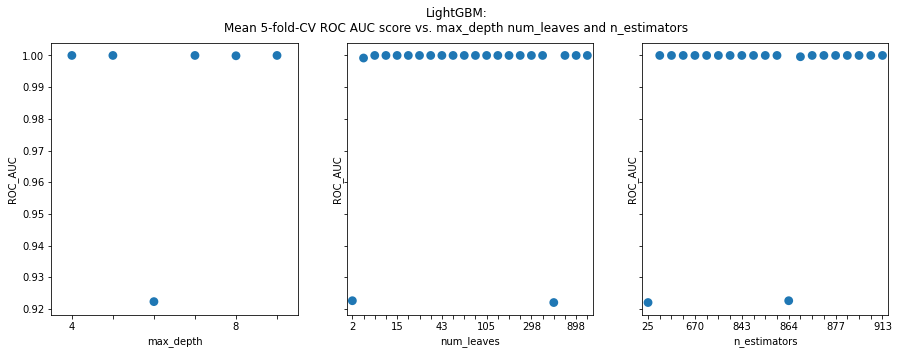

In [38]:
plot_hyperparameter_search_results('bo', 
                                   'lgbm', 
                                   'max_depth', 
                                   'num_leaves', 
                                   'n_estimators')

### Metrics

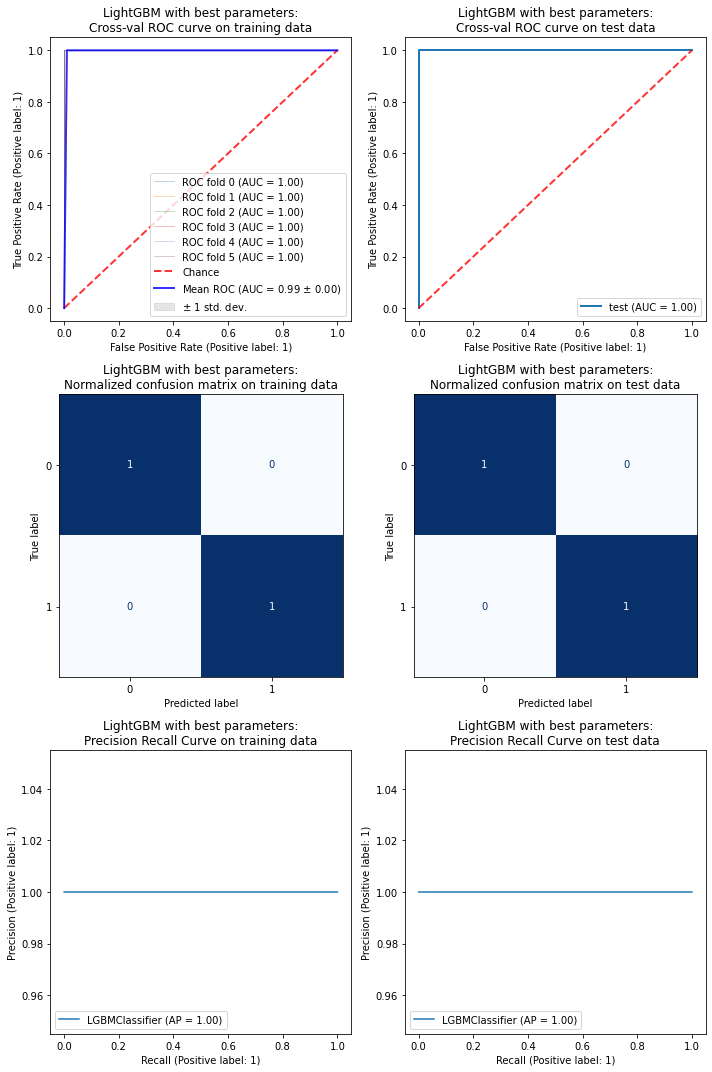

In [39]:
plot_metrics('lgbm')

We see that the LGBM is suspiciously good. It's unlikely that the model is really nearly perfect. There must be an bug in the code for the bayesian optimization of the model, but not in the grid search optimization of the same model.

## SGD Classifier


### Hyperparamater Tuning

#### Grid Search

##### Optimization

In [40]:
%%time
from sklearn.linear_model import SGDClassifier

model_str = 'sgd'

# Instantiate the classifier object
model = SGDClassifier(class_weight='balanced',
                      penalty='elasticnet',
                      max_iter=1000, 
                      tol=1e-3)

# Set parameter grid and instantiate HalvingGridSearchCV object
param_grid = {'loss':  ['hinge', 
                        'log', 
                        'modified_huber', 
                        'squared_hinge', 
                        'perceptron'],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
              }

gs = HalvingGridSearchCV(model, 
                  param_grid, 
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1, 
                  verbose=3)
    
# Fit classifier
gs.fit(X_train, y_train)

# Set the best parameters in the the classifier and fit the train data
model.set_params(**gs.best_params_) 
model.fit(X_train, y_train)

# Save the results
save_gs_search_results_and_model(gs, model_str)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2172
max_resources_: 19548
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 2172
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 1
n_candidates: 9
n_resources: 6516
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 19548
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params: {'l1_ratio': 0.5, 'loss': 'log'}
Best CV Score: 0.9203
CPU times: user 3.72 s, sys: 109 ms, total: 3.83 s
Wall time: 28.8 s


#####Results

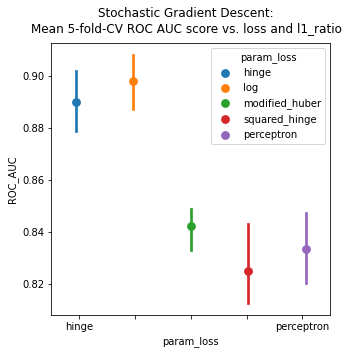

In [41]:
plot_hyperparameter_search_results('gs', 
                                   'sgd', 
                                   'loss', 
                                   'l1_ratio')

#### Bayesian Optimization

##### Optimization

In [42]:
%%time
from sklearn.linear_model import SGDClassifier

model_str = 'sgd'

# Instantiate the classifier object
model = SGDClassifier(class_weight='balanced',
                      penalty='elasticnet',
                      max_iter=30, 
                      tol=1e-3)

# Set parameter grid and instantiate HalvingGridSearchCV object
param_grid = {'loss':  ['hinge', 
                        'log', 
                        'modified_huber', 
                        'squared_hinge', 
                        'perceptron'],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

# Parameters
pbounds = {'loss': [0, 3],
           'l1_ratio': [0, 1]}

# Run optimization and save results
bo = run_bayes_opt(eval_model, 
                   pbounds,
                   n_iter = 60)

# Set model to best params and fit to train data
model.set_params(**best_params[model_str])
model.fit(X_train, y_train)
models[model_str] = model

|   iter    |  target   | l1_ratio  |   loss    |
-------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  1        |  0.867    |  0.5685   |  1.821    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  2        |  0.855    |  0.2654   |  1.945    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  3        |  0.9037   |  0.1476   |  1.431    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  4        |  0.9098   |  0.5136   |  0.8472   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  5        |  0.9172   |  0.3231   |  0.02003  |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  6        |  0.905    |  0.1925   |  0.5147   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  7        |  0.9166   |  0.3763   |  0.2928   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  8        |  0.9146   |  0.2174   |  0.1754   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  9        |  0.9078   |  0.4183   |  0.5739   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  10       |  0.9119   |  0.4088   |  0.1037   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  11       |  0.9161   |  0.3469   |  0.005258 |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  12       |  0.9173   |  0.2537   |  0.0      |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  13       |  0.917    |  0.1947   |  0.3479   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  14       |  0.9174   |  0.2982   |  0.3586   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  15       |  0.908    |  0.2527   |  0.6634   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  16       |  0.9109   |  0.3058   |  0.2262   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  17       |  0.9164   |  0.3351   |  0.4734   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  18       |  0.9072   |  0.3143   |  0.5808   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  19       |  0.9158   |  0.2978   |  0.3503   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  20       |  0.9136   |  0.2713   |  0.4443   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  21       |  0.9153   |  0.3224   |  0.4087   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  22       |  0.9028   |  0.2764   |  0.5044   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  23       |  0.9155   |  0.2786   |  0.2719   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  24       |  0.9163   |  0.3004   |  0.3575   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  25       |  0.9151   |  0.298    |  0.2859   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  26       |  0.9169   |  0.2839   |  0.4009   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  27       |  0.915    |  0.3005   |  0.3583   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  28       |  0.9156   |  0.2976   |  0.4257   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  29       |  0.9162   |  0.3004   |  0.3574   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  30       |  0.9164   |  0.2889   |  0.3537   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  31       |  0.9124   |  0.3006   |  0.3584   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  32       |  0.9161   |  0.2981   |  0.3585   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  33       |  0.9177   |  0.2985   |  0.3552   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  34       |  0.9167   |  0.3009   |  0.3543   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  35       |  0.9161   |  0.299    |  0.3527   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  36       |  0.9141   |  0.2963   |  0.3534   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  37       |  0.9163   |  0.3016   |  0.3514   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  38       |  0.9174   |  0.3003   |  0.349    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  39       |  0.9162   |  0.298    |  0.3475   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  40       |  0.914    |  0.3005   |  0.3463   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  41       |  0.9117   |  0.299    |  0.3527   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  42       |  0.9101   |  0.2986   |  0.3525   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  43       |  0.9097   |  0.2987   |  0.3529   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  44       |  0.9111   |  0.298    |  0.3553   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  45       |  0.9149   |  0.2987   |  0.3556   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  46       |  0.9159   |  0.2989   |  0.3552   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  47       |  0.9178   |  0.2986   |  0.3548   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  48       |  0.9148   |  0.299    |  0.3547   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  49       |  0.9153   |  0.2981   |  0.3548   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  50       |  0.9149   |  0.2985   |  0.3545   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  51       |  0.9147   |  0.298    |  0.3589   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  52       |  0.9162   |  0.2985   |  0.3582   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  53       |  0.9145   |  0.2987   |  0.3586   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  54       |  0.9157   |  0.2984   |  0.359    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  55       |  0.9161   |  0.2981   |  0.358    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  56       |  0.9145   |  0.2985   |  0.3578   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  57       |  0.9157   |  0.2989   |  0.3581   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

|  58       |  0.9157   |  0.2981   |  0.3576   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  59       |  0.9169   |  0.299    |  0.3577   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  60       |  0.9113   |  0.2987   |  0.3574   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  61       |  0.9166   |  0.2989   |  0.3543   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  62       |  0.9147   |  0.2986   |  0.354    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  63       |  0.9163   |  0.2986   |  0.3549   |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  64       |  0.915    |  0.2983   |  0.3559   |
Saved file to /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/models/2021-04-24 2031 Stochastic Gradient Descent df_bayes_opt_results_parameters.pkl
Saved file to /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/models/2021-04-24 2031 Stochastic Gradient Descent df_bayes_opt_results_parameters.csv
CPU times: user 5min 25s, sys: 2min 1s, total: 7min 27s
Wall time: 5min 11s


##### Results

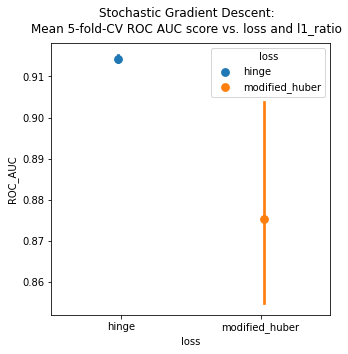

In [43]:
plot_hyperparameter_search_results('bo', 
                                   'sgd', 
                                   'loss', 
                                   'l1_ratio')

### Metrics

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


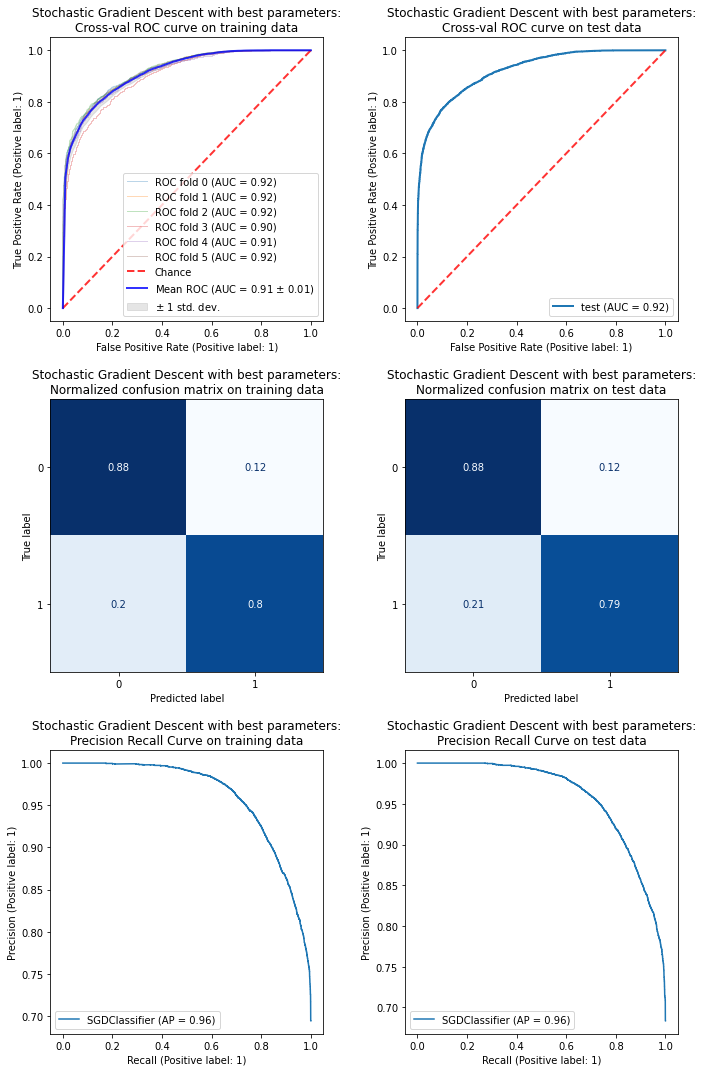

In [44]:
plot_metrics('sgd')

The SGD model doesn't reach the high scores of the other models though it trained quickly.

## Section Summary

# Modeling on Non-feature-engineered Data

All the modeling above used data that was feature engineered by grouping some categorical data and calculating basic numberical aggregate data for each group, then deleting the original categorical feature. The resulting data has a shape of approxamately (20000, 200).

Before feature engineering, the training data had a shape of approxamately (20000, 18000). There were thousands of permutations of tags, content_id's, bundle_id's, etc.

Let's take a look at the results of modeling on the non-feature-engineered data.


## Hyperparameter Tuning

### Decision tree


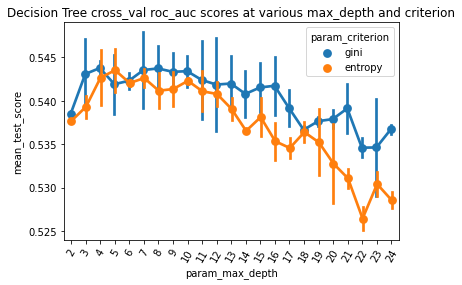

We found that performance was maximixed for max_depth between 2 and 4. 

Also, we see that criterion 'gini' is superior to 'entropy'.



### Random Forest

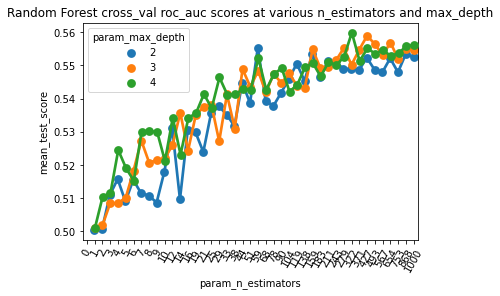


We find that performance is maximized with max_depth of 4, 

and n_estimators of 150 to 400.


### Logistic Regression

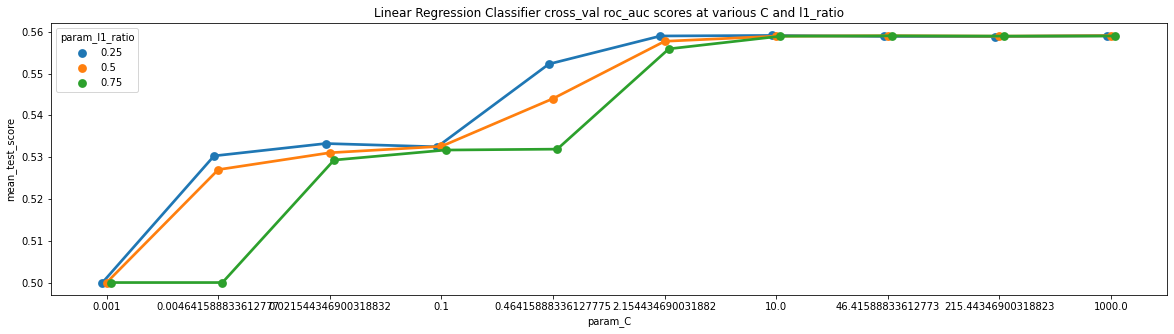

We find that performace is maximized for:

* C between 0.4 and 2,

* l1_ratio of 0.25



### LightGBM

We find the best hyperparameters are:

* max depth: 1 or 2,

* n_estimators: 16 to 77,

* num_leaves: any,



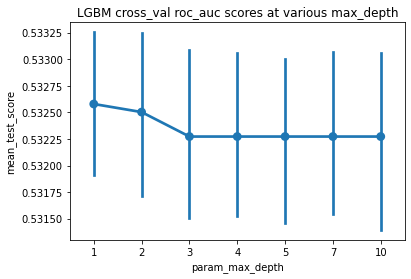

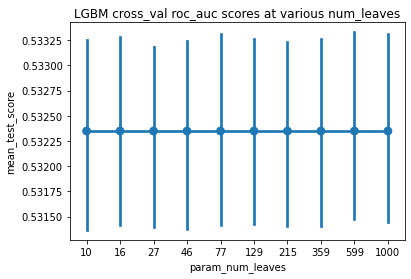

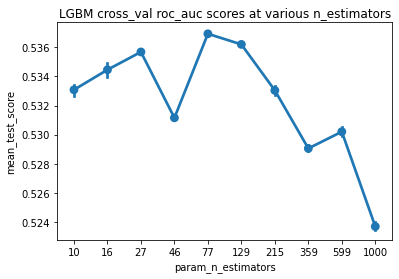

## Metrics

#### Decision tree


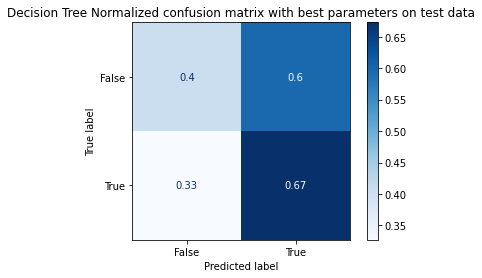

#### Random Forest

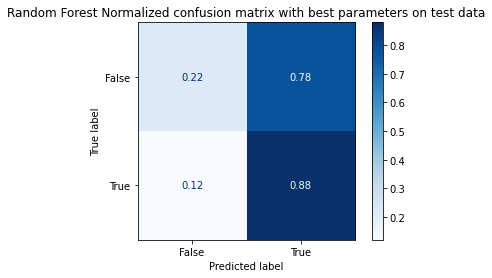

#### Logistic Regression

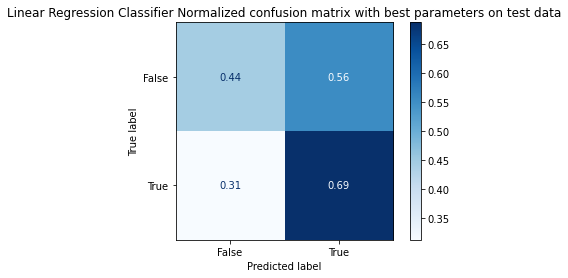

#### LightGBM

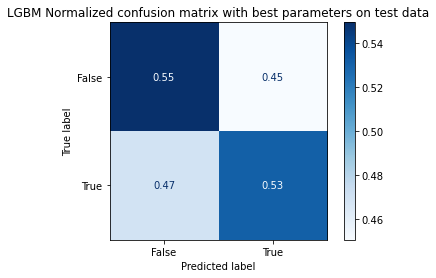

## Section Summary

It's obvious that feature enginering greatly improved all the models. Surprisingly, one ensemble method model--random forest--didn't do so badly on the un-engineered data, but the other--LightGBM--did terribly.

# Conclusion

We see that all of the five models are capable of predicting the correctness outcomes of students answers to homework questions, with ROC-AUC scores of greater than 0.85 on the test data. We'll consider the supiciouisly high score for LightGBM in another notebook.

All models were trained on approxamately 20000 events, and tested on approxamately 20000 unseen events.

Before feature engineering, all models did considerably poorer, with no model scoring better than 0.60. The feature engineering resulted in a signifcant dimensionality reduction that helped the model's focus on the most important features sooner, and greatly reduced the training time.

## Future topics to explore
As many of the models score similarly, There are other factors to explore that will inform model selection. This topics include:
* Training speed
* Prediction speed
* Memory requirements
* Current or future GPU/TPU architecture support
* Availability of implementations in distributed computing
